# 3 - Modélisation supervisée

Dans ce notebook, nous poursuivons l'analyse du dataset *Vinho Verde* débutée lors de l'exploration et la préparation des données. Après avoir nettoyé, normalisé et équilibré notre jeu de données, nous abordons ici la **modélisation supervisée**, dont l'objectif est de **prédire la qualité du vin** à partir de ses caractéristiques physico-chimiques.

Nous mettrons en œuvre différentes approches d’apprentissage supervisé, à la fois **linéaires** (régression logistique, analyse discriminante) et **non linéaires** (arbres de décision, méthodes ensemblistes), en suivant rigoureusement les bonnes pratiques d’évaluation (validation croisée, métriques variées).

## Sommaire

1. Chargement des jeux de données préparés (normalisé et SMOTE)
2. Rappel sur le problème de classification et la nature de la variable cible
3. Séparation des données en ensembles d'entraînement et de test
4. Modélisation avec plusieurs algorithmes supervisés
5. Évaluation des performances (accuracy, f1-score, matrice de confusion…)
6. Sélection du ou des meilleurs modèles
7. Interprétation et visualisation des résultats

In [26]:
# imports
import os
import pandas as pd
from pandas import DataFrame
from typing import Tuple
from pandas import Series
from sklearn.model_selection import train_test_split
from sklearn.base import ClassifierMixin
from sklearn.model_selection import StratifiedKFold, cross_val_score
from typing import Union, Literal
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression

## 1. Chargement des jeux de données préparés

Nous chargeons ici deux versions du jeu de données Vinho Verde :
- `WineQT_normalized.csv` : données réelles, normalisées, avec la variable `quality_cat`.
- `WineQT_SMOTE.csv` : version équilibrée via SMOTE pour la classification.

Ces jeux sont le résultat du travail de préparation réalisé dans le premier notebook.


In [27]:
# Chargement des données
path_normalized: str = os.path.join(os.path.dirname(
    os.getcwd()), "data", "WineQT_normalized.csv")
path_smote: str = os.path.join(os.path.dirname(
    os.getcwd()), "data", "WineQT_SMOTE.csv")

data_normalized: DataFrame = pd.read_csv(path_normalized, index_col="Id")
data_smote: DataFrame = pd.read_csv(path_smote, index_col="Id")

## 2. Rappel sur le problème de classification

Notre objectif est de prédire la qualité d’un vin à partir de ses caractéristiques physico-chimiques.

- La variable cible `quality` est à l'origine un entier entre 1 et 10 (uniquement les valeurs allant de 3 à 8 sont présentes dans notre jeu de données mais la description du dataset nous indique que la note est sur 10).
- Elle a été regroupée en 3 classes ordinales :
    - **faible** : notes 3 et 4
    - **moyenne** : notes 5 et 6
    - **bonne** : notes 7 et 8

Ce problème peut donc être traité comme :
- **Une classification multiclasse** 
- **Une classification ordinale** 
- **Une classification binaire** 

Dans ce notebook nous allons uniquement traiter ce problème comme **une classification multiclasse** (faible, moyenne, bonne)
et nous utiliserons les labels **encodés** (0, 1, 2) à partir de `quality_cat`.


## 3. Séparation des données en ensembles d'entraînement et de test

### a. Séparation des données

Nous utilisons ici la version équilibrée `data_smote`, qui permet un apprentissage sans biais de classe.

Étapes :
- Séparation de la cible (`y`) et des variables explicatives (`X`)
- Séparation `train/test` (80/20) avec stratification pour préserver l'équilibre entre classes
- Encodage des labels avec `LabelEncoder` si besoin (déjà fait ici)


In [28]:
# Séparation des features et de la cible
target_col: str = "quality_encoded"
feature_cols: list[str] = [
    col for col in data_smote.columns if col not in ["quality_cat", target_col]]

X: DataFrame = data_smote[feature_cols]
y: Series = data_smote[target_col]

# Découpage en train/test (stratifié)
X_train: DataFrame
X_test: DataFrame
y_train: Series
y_test: Series

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Vérification des dimensions
print(f"X_train : {X_train.shape}, X_test : {X_test.shape}")
print(f"y_train : {y_train.shape}, y_test : {y_test.shape}")

X_train : (2020, 11), X_test : (506, 11)
y_train : (2020,), y_test : (506,)


### b. Validation croisée 

Avant de tester nos modèles sur le jeu de test, nous utilisons la validation croisée pour évaluer leur performance **de façon plus robuste** sur les données d'entraînement.

Nous utilisons ici une validation croisée en **5 plis** (`k=5`) :
- L’ensemble `X_train` est divisé en 5 sous-ensembles (folds)
- À chaque itération, 4 folds servent à l'entraînement, 1 fold à la validation
- On calcule la **moyenne** des scores sur les 5 itérations

Cela permet de limiter les biais liés à un découpage unique du dataset et de comparer plus rigoureusement les modèles.


In [29]:
# Fonction pour évaluer un modèle de classification
def evaluate_model_cv(
    model: ClassifierMixin,
    X: DataFrame,
    y: Series,
    scoring: Literal["f1_macro", "accuracy",
                     "recall_macro", "precision_macro"] = "f1_macro",
    k: int = 5
) -> np.ndarray:
    """
    Effectue une validation croisée sur un modèle de classification.

    Args:
        model (ClassifierMixin): Le modèle à évaluer (doit implémenter .fit() et .predict()).
        X (DataFrame): Variables explicatives.
        y (Series): Variable cible.
        scoring (str): Métrique d’évaluation (par défaut : "f1_macro").
        k (int): Nombre de plis pour la validation croisée (par défaut : 5).

    Returns:
        np.ndarray: Liste des scores obtenus sur chaque fold.
    """
    cv: StratifiedKFold = StratifiedKFold(
        n_splits=k, shuffle=True, random_state=42)
    scores: np.ndarray = cross_val_score(model, X, y, cv=cv, scoring=scoring)

    print(f"Scores ({scoring}) : {scores}")
    print(f"Moyenne : {scores.mean():.4f}, Écart-type : {scores.std():.4f}")

    return scores

In [30]:
# Fonction pour afficher les scores de validation croisée
def plot_cv_scores(
    scores: np.ndarray,
    model_name: str,
    metric: Literal["f1_macro", "accuracy",
                    "recall_macro", "precision_macro"] = "f1_macro"
) -> None:
    """
    Affiche un graphique en barres des scores de validation croisée.

    Args:
        scores (np.ndarray): Liste des scores par fold.
        model_name (str): Nom du modèle affiché dans le titre.
        metric (str): Métrique utilisée (affichée sur l’axe Y).
    """
    plt.figure(figsize=(8, 4))
    sns.barplot(
        x=list(range(1, len(scores) + 1)),
        y=scores,
        hue=scores,
        palette="Set2",
        edgecolor="black",
        legend=False
    )
    plt.ylim(0, 1)
    plt.title(f"{model_name} – Scores {metric} par fold")
    plt.xlabel("Fold")
    plt.ylabel(f"{metric}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Scores (f1_macro) : [0.69137186 0.69333974 0.73433696 0.69199414 0.72446965]
Moyenne : 0.7071, Écart-type : 0.0185


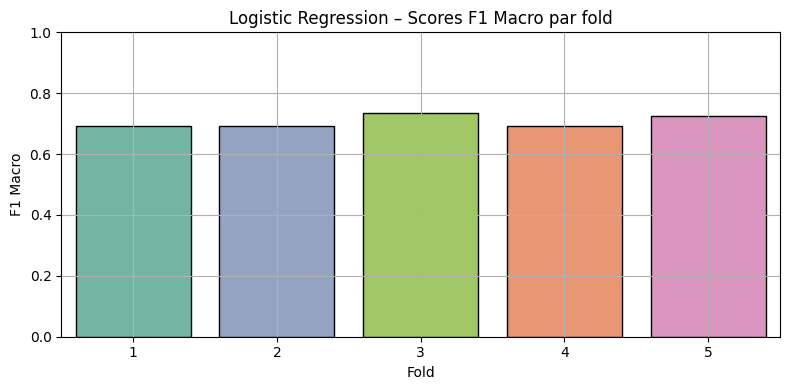

In [31]:
# Modèle à évaluer
logreg: LogisticRegression = LogisticRegression(
    solver="lbfgs", max_iter=1000, random_state=42
)

# Évaluation en validation croisée (F1_macro sur train set)
scores_logreg: np.ndarray = evaluate_model_cv(
    model=logreg,
    X=X_train,
    y=y_train,
    scoring="f1_macro",
    k=5
)

# Affichage des scores
plot_cv_scores(
    scores=scores_logreg,
    model_name="Logistic Regression",
    metric="F1 Macro"
)

#### Interprétation des résultats de la validation croisée

Nous avons évalué la performance de la régression logistique multinomiale à l’aide d’une validation croisée stratifiée à 5 plis. Les scores obtenus pour la métrique `f1_macro` sont les suivants :

- **Scores par fold** : [0.691, 0.693, 0.734, 0.692, 0.724]
- **Moyenne** : **0.707**
- **Écart-type** : **0.018**

####  Analyse

- Le **score moyen de 0.707** indique que le modèle a une **bonne capacité à prédire correctement les trois classes** (faible, moyenne, bonne), en tenant compte de l’équilibre entre elles.
- L’**écart-type faible (0.018)** montre que le modèle est **stable** : ses performances ne varient pas fortement d’un pli à l’autre, ce qui est un signe de généralisation correcte.
- Il reste possible de **l’améliorer** par une meilleure régularisation, un tuning d’hyperparamètres, ou des modèles non linéaires (comme les arbres ou le gradient boosting).

Ces résultats servent de **référence de base** pour comparer les modèles plus complexes dans la suite du notebook.
